<a href="https://colab.research.google.com/github/anhdung28888/deep-cf/blob/master/MxNet_Deep_Collaborative_Filtering_ml_20m_thesis_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Environment setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# Confirm that you have CUDA 10
!nvcc --version

# Install CUDA10-compatible version of mxnet
!cp /content/drive/My\ Drive/Bigdata/ml-20m/mxnet_setup/mxnet_cu101-1.6.0-py2.py3-none-manylinux1_x86_64.whl mxnet_cu101-1.6.0-py2.py3-none-manylinux1_x86_64.whl # restore package for offline installation
!pip install mxnet_cu101-1.6.0-py2.py3-none-manylinux1_x86_64.whl # !pip install mxnet-cu101 # online installation

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
Processing ./mxnet_cu101-1.6.0-py2.py3-none-manylinux1_x86_64.whl
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [ ]:
%pylab inline
import mxnet as mx
import pandas
import seaborn; seaborn.set_style('whitegrid')
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
import os
import urllib.request
import zipfile

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Now load it up using a pandas dataframe
# movielens-20m
data = pandas.read_csv('/content/drive/My Drive/Bigdata/ml-20m/ratings.csv') #movielens-20m
# data.head()
print("user id min/max: ", data['userId'].min(), data['userId'].max())
print("# unique users: ", numpy.unique(data['userId']).shape[0])
print("")
print("movie id min/max: ", data['movieId'].min(), data['movieId'].max())
print("# unique movies: ", numpy.unique(data['movieId']).shape[0])

user id min/max:  1 138493
# unique users:  138493

movie id min/max:  1 131262
# unique movies:  26744


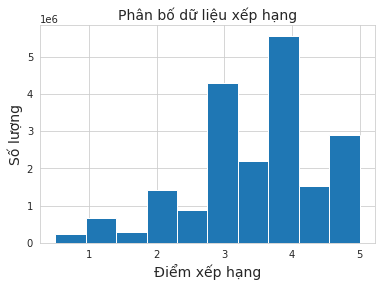

In [ ]:
plt.hist(data['rating'])
plt.xlabel("Điểm xếp hạng", fontsize=14)
plt.ylabel("Số lượng", fontsize=14)
plt.title("Phân bố dữ liệu xếp hạng", fontsize=14)
plt.show()

In [ ]:
n_users, n_movies = 138493, 131262 #movielen
batch_size = 25000

Shuffle and split data for training and testing

In [ ]:
#movielens
n = 19000000

data = data.sample(frac=1).reset_index(drop=True) # Shuffle the data in place row-wise

# Use the first 18M samples to train the model
train_users = data['userId'].values[:n] - 1 # Offset by 1 so that the IDs start at 0
train_movies = data['movieId'].values[:n] - 1 # Offset by 1 so that the IDs start at 0
train_ratings = data['rating'].values[:n]

# Use the remaining ~1M samples for validation of the model
valid_users = data['userId'].values[n:] - 1 # Offset by 1 so that the IDs start at 0
valid_movies = data['movieId'].values[n:] - 1 # Offset by 1 so that the IDs start at 0
valid_ratings = data['rating'].values[n:]

In [ ]:
genres = pandas.read_csv('/content/drive/My Drive/Bigdata/ml-20m/movies.csv')

# Create id for each genre text
labels_str = [label.split("|")[0] for label in genres['genres']]
label_set = numpy.unique(labels_str) # query unique labels
label_idxs = {l: i for i, l in enumerate(label_set)} # assign id for each label

# Map first genre to each movie
labels = numpy.empty(n_movies)
for movieId, label in zip(genres['movieId'], labels_str):
    labels[movieId-1] = label_idxs[label]

# Split movie-genre to train and test set
train_genres = numpy.array([labels[int(j)] for j in train_movies])
valid_genres = numpy.array([labels[int(j)] for j in valid_movies])

In [ ]:
# # Load tag relevance scores
# genome_scores = pandas.read_csv('/content/drive/My Drive/Bigdata/ml-20m/genome-scores.csv')
# # Find the highest relevant tag for each movie
# idx = genome_scores.groupby(['movieId'])['relevance'].transform(max) == genome_scores['relevance'] 
# tags = genome_scores[idx]
# # Save to later use
# tags.to_csv('/content/drive/My Drive/Bigdata/ml-20m/df_tag.csv',index=False)

# Reload most relevant tags
tags = pandas.read_csv('/content/drive/My Drive/Bigdata/ml-20m/df_tag.csv')

# Map tag to each movie
label_tag = numpy.empty(n_movies)
for movieId, tagid in zip(tags['movieId'], tags['tagId']):
    label_tag[movieId-1] = tagid

## Funk MF

In [ ]:
#movielens with userid, itemid as integer
X_train = mx.io.NDArrayIter({'user': train_users, 'movie': train_movies}, 
                           label=train_ratings, batch_size=batch_size)
X_eval = mx.io.NDArrayIter({'user': valid_users, 'movie': valid_movies}, 
                          label=valid_ratings, batch_size=batch_size)

user = mx.symbol.Variable("user")
user = mx.symbol.Embedding(data=user, input_dim=n_users, output_dim=25)

movie = mx.symbol.Variable("movie")
movie = mx.symbol.Embedding(data=movie, input_dim=n_movies, output_dim=25)

y_true = mx.symbol.Variable("softmax_label")
y_pred = mx.symbol.sum_axis(data=(user * movie), axis=1)
y_pred = mx.symbol.flatten(y_pred)
y_pred = mx.symbol.LinearRegressionOutput(data=y_pred, label=y_true)

model = mx.module.Module(context=mx.gpu(0), data_names=('user', 'movie'), symbol=y_pred)
model.fit(X_train, 
          num_epoch=50, 
          optimizer='adam', 
          optimizer_params=(('learning_rate', 0.001),),
          eval_metric='rmse', 
          eval_data=X_eval, 
          batch_end_callback=mx.callback.Speedometer(batch_size, 250))

INFO:root:Epoch[0] Batch [0-250]	Speed: 13951688.74 samples/sec	rmse=3.384712
INFO:root:Epoch[0] Batch [250-500]	Speed: 14263336.10 samples/sec	rmse=1.825848
INFO:root:Epoch[0] Batch [500-750]	Speed: 14165321.16 samples/sec	rmse=1.181800
INFO:root:Epoch[0] Train-rmse=2.119840
INFO:root:Epoch[0] Time cost=1.456
INFO:root:Epoch[0] Validation-rmse=1.060756
INFO:root:Epoch[1] Batch [0-250]	Speed: 14632621.53 samples/sec	rmse=1.003288
INFO:root:Epoch[1] Batch [250-500]	Speed: 14212506.64 samples/sec	rmse=0.937666
INFO:root:Epoch[1] Batch [500-750]	Speed: 14247428.85 samples/sec	rmse=0.905599
INFO:root:Epoch[1] Train-rmse=0.948315
INFO:root:Epoch[1] Time cost=1.334
INFO:root:Epoch[1] Validation-rmse=0.897679
INFO:root:Epoch[2] Batch [0-250]	Speed: 14423154.16 samples/sec	rmse=0.888487
INFO:root:Epoch[2] Batch [250-500]	Speed: 14368117.23 samples/sec	rmse=0.880021
INFO:root:Epoch[2] Batch [500-750]	Speed: 14369078.07 samples/sec	rmse=0.873487
INFO:root:Epoch[2] Train-rmse=0.880578
INFO:root:E

#DCF (4 layers)

In [ ]:
X_train = mx.io.NDArrayIter({'user': train_users, 
                             'movie': train_movies}, 
                            label=train_ratings, 
                            batch_size=batch_size)
X_eval = mx.io.NDArrayIter({'user': valid_users, 
                            'movie': valid_movies}, 
                           label=valid_ratings, 
                           batch_size=batch_size)

user = mx.symbol.Variable("user")
user = mx.symbol.Embedding(data=user, input_dim=n_users, output_dim=25) 
movie = mx.symbol.Variable("movie")
movie = mx.symbol.Embedding(data=movie, input_dim=n_movies, output_dim=25) 

y_true = mx.symbol.Variable("softmax_label")

nn = mx.symbol.concat(user, movie)
nn = mx.symbol.flatten(nn)

# Since we are using a two layer neural network here, we will create two FullyConnected layers
# with activation functions before the output layer
nn = mx.symbol.FullyConnected(data=nn, num_hidden=128)
nn = mx.symbol.Activation(data=nn, act_type='relu')
nn = mx.symbol.FullyConnected(data=nn, num_hidden=64)
nn = mx.symbol.Activation(data=nn, act_type='relu')
nn = mx.symbol.FullyConnected(data=nn, num_hidden=32)
nn = mx.symbol.Activation(data=nn, act_type='relu')
nn = mx.symbol.FullyConnected(data=nn, num_hidden=1)
y_pred = mx.symbol.LinearRegressionOutput(data=nn, label=y_true)

model = mx.module.Module(context=mx.gpu(0), data_names=('user', 'movie'), symbol=y_pred)
model.fit(X_train, num_epoch=50, optimizer='adam', optimizer_params=(('learning_rate', 0.001),),
          eval_metric='rmse', eval_data=X_eval, batch_end_callback=mx.callback.Speedometer(batch_size, 250))

INFO:root:Epoch[0] Batch [0-250]	Speed: 7603004.73 samples/sec	rmse=1.502449
INFO:root:Epoch[0] Batch [250-500]	Speed: 7690824.99 samples/sec	rmse=0.867094
INFO:root:Epoch[0] Batch [500-750]	Speed: 7684557.45 samples/sec	rmse=0.860139
INFO:root:Epoch[0] Train-rmse=1.074485
INFO:root:Epoch[0] Time cost=2.559
INFO:root:Epoch[0] Validation-rmse=0.853476
INFO:root:Epoch[1] Batch [0-250]	Speed: 7670688.05 samples/sec	rmse=0.847852
INFO:root:Epoch[1] Batch [250-500]	Speed: 7674458.50 samples/sec	rmse=0.839065
INFO:root:Epoch[1] Batch [500-750]	Speed: 7658553.06 samples/sec	rmse=0.833511
INFO:root:Epoch[1] Train-rmse=0.840045
INFO:root:Epoch[1] Time cost=2.483
INFO:root:Epoch[1] Validation-rmse=0.834759
INFO:root:Epoch[2] Batch [0-250]	Speed: 7653667.35 samples/sec	rmse=0.827756
INFO:root:Epoch[2] Batch [250-500]	Speed: 7684458.34 samples/sec	rmse=0.822500
INFO:root:Epoch[2] Batch [500-750]	Speed: 7674609.04 samples/sec	rmse=0.819225
INFO:root:Epoch[2] Train-rmse=0.823099
INFO:root:Epoch[2] T

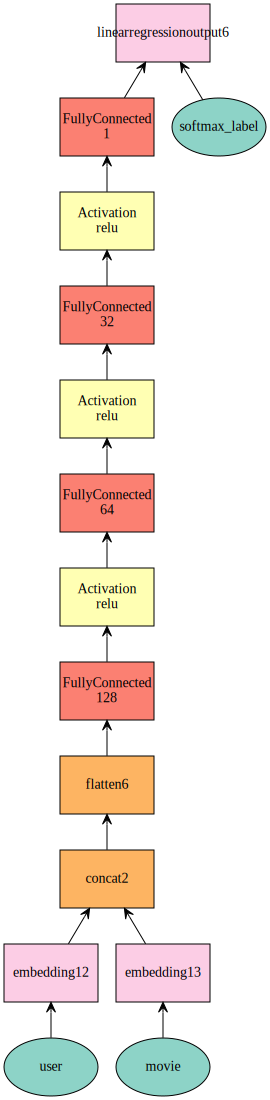

In [ ]:
# Visualize network
mx.viz.plot_network(y_pred)

In [ ]:
# Print network summary
mx.viz.print_summary(y_pred)

________________________________________________________________________________________________________________________
Layer (type)                                        Output Shape            Param #     Previous Layer                  
user(null)                                                                  0                                           
________________________________________________________________________________________________________________________
embedding12(Embedding)                                                      3462325     user                            
________________________________________________________________________________________________________________________
embedding13(Embedding)                                                      3281550                                     
________________________________________________________________________________________________________________________
concat2(Concat)                 

## 5-layer

In [ ]:
X_train = mx.io.NDArrayIter({'user': train_users, 
                             'movie': train_movies}, 
                            label=train_ratings, 
                            batch_size=batch_size)
X_eval = mx.io.NDArrayIter({'user': valid_users, 
                            'movie': valid_movies}, 
                           label=valid_ratings, 
                           batch_size=batch_size)

user = mx.symbol.Variable("user")
user = mx.symbol.Embedding(data=user, input_dim=n_users, output_dim=25) 
movie = mx.symbol.Variable("movie")
movie = mx.symbol.Embedding(data=movie, input_dim=n_movies, output_dim=25) 

y_true = mx.symbol.Variable("softmax_label")

nn = mx.symbol.concat(user, movie)
nn = mx.symbol.flatten(nn)

# Since we are using a two layer neural network here, we will create two FullyConnected layers
# with activation functions before the output layer
nn = mx.symbol.FullyConnected(data=nn, num_hidden=128)
nn = mx.symbol.Activation(data=nn, act_type='relu')
nn = mx.symbol.FullyConnected(data=nn, num_hidden=64)
nn = mx.symbol.Activation(data=nn, act_type='relu')
nn = mx.symbol.FullyConnected(data=nn, num_hidden=32)
nn = mx.symbol.Activation(data=nn, act_type='relu')
nn = mx.symbol.FullyConnected(data=nn, num_hidden=16)
nn = mx.symbol.Activation(data=nn, act_type='relu')
nn = mx.symbol.FullyConnected(data=nn, num_hidden=1)
y_pred = mx.symbol.LinearRegressionOutput(data=nn, label=y_true)

model = mx.module.Module(context=mx.gpu(0), data_names=('user', 'movie'), symbol=y_pred)
model.fit(X_train, num_epoch=50, optimizer='adam', optimizer_params=(('learning_rate', 0.001),),
          eval_metric='rmse', eval_data=X_eval, batch_end_callback=mx.callback.Speedometer(batch_size, 250))

INFO:root:Epoch[0] Batch [0-250]	Speed: 6970389.19 samples/sec	rmse=1.562601
INFO:root:Epoch[0] Batch [250-500]	Speed: 7081610.17 samples/sec	rmse=0.866865
INFO:root:Epoch[0] Batch [500-750]	Speed: 7065639.85 samples/sec	rmse=0.859361
INFO:root:Epoch[0] Train-rmse=1.094008
INFO:root:Epoch[0] Time cost=2.772
INFO:root:Epoch[0] Validation-rmse=0.852288
INFO:root:Epoch[1] Batch [0-250]	Speed: 7085401.93 samples/sec	rmse=0.845418
INFO:root:Epoch[1] Batch [250-500]	Speed: 7089863.06 samples/sec	rmse=0.836562
INFO:root:Epoch[1] Batch [500-750]	Speed: 7081281.14 samples/sec	rmse=0.831500
INFO:root:Epoch[1] Train-rmse=0.837728
INFO:root:Epoch[1] Time cost=2.689
INFO:root:Epoch[1] Validation-rmse=0.832639
INFO:root:Epoch[2] Batch [0-250]	Speed: 7067489.53 samples/sec	rmse=0.824740
INFO:root:Epoch[2] Batch [250-500]	Speed: 7088478.90 samples/sec	rmse=0.820413
INFO:root:Epoch[2] Batch [500-750]	Speed: 7075079.34 samples/sec	rmse=0.816967
INFO:root:Epoch[2] Train-rmse=0.820625
INFO:root:Epoch[2] T

## 3-layer

In [ ]:
X_train = mx.io.NDArrayIter({'user': train_users, 
                             'movie': train_movies}, 
                            label=train_ratings, 
                            batch_size=batch_size)
X_eval = mx.io.NDArrayIter({'user': valid_users, 
                            'movie': valid_movies}, 
                           label=valid_ratings, 
                           batch_size=batch_size)

user = mx.symbol.Variable("user")
user = mx.symbol.Embedding(data=user, input_dim=n_users, output_dim=25) 
movie = mx.symbol.Variable("movie")
movie = mx.symbol.Embedding(data=movie, input_dim=n_movies, output_dim=25) 

y_true = mx.symbol.Variable("softmax_label")

nn = mx.symbol.concat(user, movie)
nn = mx.symbol.flatten(nn)

# Since we are using a two layer neural network here, we will create two FullyConnected layers
# with activation functions before the output layer
nn = mx.symbol.FullyConnected(data=nn, num_hidden=32)
nn = mx.symbol.Activation(data=nn, act_type='relu')
nn = mx.symbol.FullyConnected(data=nn, num_hidden=16)
nn = mx.symbol.Activation(data=nn, act_type='relu')
nn = mx.symbol.FullyConnected(data=nn, num_hidden=1)
y_pred = mx.symbol.LinearRegressionOutput(data=nn, label=y_true)

model = mx.module.Module(context=mx.gpu(0), data_names=('user', 'movie'), symbol=y_pred)
model.fit(X_train, num_epoch=50, optimizer='adam', optimizer_params=(('learning_rate', 0.001),),
          eval_metric='rmse', eval_data=X_eval, batch_end_callback=mx.callback.Speedometer(batch_size, 250))

INFO:root:Epoch[0] Batch [0-250]	Speed: 10798782.14 samples/sec	rmse=1.766832
INFO:root:Epoch[0] Batch [250-500]	Speed: 9820352.55 samples/sec	rmse=0.876661
INFO:root:Epoch[0] Batch [500-750]	Speed: 10960269.52 samples/sec	rmse=0.866327
INFO:root:Epoch[0] Train-rmse=1.167111
INFO:root:Epoch[0] Time cost=1.878
INFO:root:Epoch[0] Validation-rmse=0.864061
INFO:root:Epoch[1] Batch [0-250]	Speed: 10958853.71 samples/sec	rmse=0.861641
INFO:root:Epoch[1] Batch [250-500]	Speed: 10920123.19 samples/sec	rmse=0.859319
INFO:root:Epoch[1] Batch [500-750]	Speed: 11121099.52 samples/sec	rmse=0.858477
INFO:root:Epoch[1] Train-rmse=0.859798
INFO:root:Epoch[1] Time cost=1.734
INFO:root:Epoch[1] Validation-rmse=0.859562
INFO:root:Epoch[2] Batch [0-250]	Speed: 11071588.76 samples/sec	rmse=0.856035
INFO:root:Epoch[2] Batch [250-500]	Speed: 11031900.87 samples/sec	rmse=0.850538
INFO:root:Epoch[2] Batch [500-750]	Speed: 11034199.44 samples/sec	rmse=0.844908
INFO:root:Epoch[2] Train-rmse=0.850409
INFO:root:Ep

# Genre DCF model (4-layer)


In [ ]:
X_train = mx.io.NDArrayIter({'user': train_users, 
                             'movie': train_movies, 
                             'movie_genre': train_genres}, 
                            label=train_ratings, batch_size=batch_size)
X_eval = mx.io.NDArrayIter({'user': valid_users, 
                            'movie': valid_movies, 
                            'movie_genre': valid_genres}, 
                           label=valid_ratings, batch_size=batch_size)

user = mx.symbol.Variable("user")
user = mx.symbol.Embedding(data=user, input_dim=n_users, output_dim=25)

movie = mx.symbol.Variable("movie")
movie = mx.symbol.Embedding(data=movie, input_dim=n_movies, output_dim=25) 

# We need to add in a third embedding layer for genre
movie_genre = mx.symbol.Variable("movie_genre")
movie_genre = mx.symbol.Embedding(data=movie_genre, input_dim=20, output_dim=5) # Set to 5

y_true = mx.symbol.Variable("softmax_label")

nn = mx.symbol.concat(user, movie, movie_genre)
nn = mx.symbol.flatten(nn)
nn = mx.symbol.FullyConnected(data=nn, num_hidden=128)
nn = mx.symbol.Activation(data=nn, act_type='relu')
nn = mx.symbol.FullyConnected(data=nn, num_hidden=64)
nn = mx.symbol.Activation(data=nn, act_type='relu')
nn = mx.symbol.FullyConnected(data=nn, num_hidden=32)
nn = mx.symbol.Activation(data=nn, act_type='relu')
nn = mx.symbol.FullyConnected(data=nn, num_hidden=1)

y_pred = mx.symbol.LinearRegressionOutput(data=nn, label=y_true)

model = mx.module.Module(context=mx.gpu(0), data_names=('user', 'movie', 'movie_genre'), symbol=y_pred)
model.fit(X_train, num_epoch=50, optimizer='adam', optimizer_params=(('learning_rate', 0.001),),
          eval_metric='rmse', eval_data=X_eval, batch_end_callback=mx.callback.Speedometer(batch_size, 250)) #num_epoch=5

INFO:root:Epoch[0] Batch [0-250]	Speed: 5880514.81 samples/sec	rmse=1.456449
INFO:root:Epoch[0] Batch [250-500]	Speed: 6510291.91 samples/sec	rmse=0.866223
INFO:root:Epoch[0] Batch [500-750]	Speed: 6471429.03 samples/sec	rmse=0.859040
INFO:root:Epoch[0] Train-rmse=1.058635
INFO:root:Epoch[0] Time cost=3.123
INFO:root:Epoch[0] Validation-rmse=0.852627
INFO:root:Epoch[1] Batch [0-250]	Speed: 6503622.91 samples/sec	rmse=0.845813
INFO:root:Epoch[1] Batch [250-500]	Speed: 6460985.01 samples/sec	rmse=0.837187
INFO:root:Epoch[1] Batch [500-750]	Speed: 6467577.98 samples/sec	rmse=0.832509
INFO:root:Epoch[1] Train-rmse=0.838423
INFO:root:Epoch[1] Time cost=2.941
INFO:root:Epoch[1] Validation-rmse=0.834360
INFO:root:Epoch[2] Batch [0-250]	Speed: 6523664.53 samples/sec	rmse=0.828605
INFO:root:Epoch[2] Batch [250-500]	Speed: 6574203.55 samples/sec	rmse=0.826223
INFO:root:Epoch[2] Batch [500-750]	Speed: 6549475.47 samples/sec	rmse=0.822236
INFO:root:Epoch[2] Train-rmse=0.825627
INFO:root:Epoch[2] T

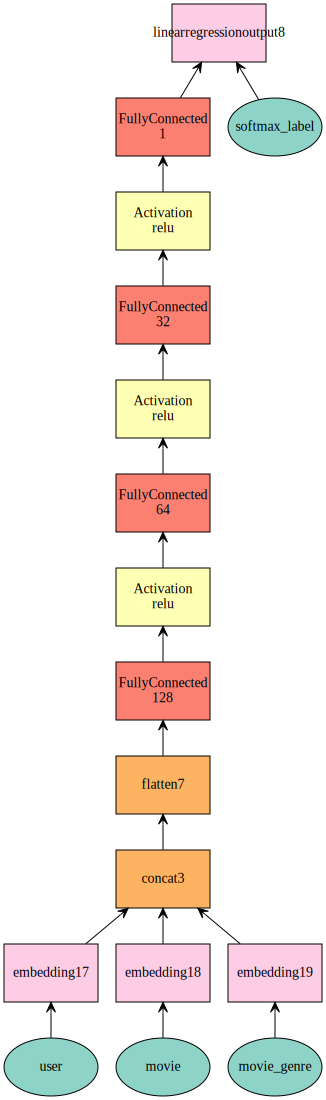

In [ ]:
# Visualize network
mx.viz.plot_network(y_pred)

In [ ]:
# Print network summary
mx.viz.print_summary(y_pred)

________________________________________________________________________________________________________________________
Layer (type)                                        Output Shape            Param #     Previous Layer                  
user(null)                                                                  0                                           
________________________________________________________________________________________________________________________
embedding17(Embedding)                                                      3462325     user                            
________________________________________________________________________________________________________________________
embedding18(Embedding)                                                      3281550                                     
________________________________________________________________________________________________________________________
embedding19(Embedding)          

## 3-layer Genre

In [ ]:
X_train = mx.io.NDArrayIter({'user': train_users, 
                             'movie': train_movies, 
                             'movie_genre': train_genres}, 
                            label=train_ratings, batch_size=batch_size)
X_eval = mx.io.NDArrayIter({'user': valid_users, 
                            'movie': valid_movies, 
                            'movie_genre': valid_genres}, 
                           label=valid_ratings, batch_size=batch_size)

user = mx.symbol.Variable("user")
user = mx.symbol.Embedding(data=user, input_dim=n_users, output_dim=25)

movie = mx.symbol.Variable("movie")
movie = mx.symbol.Embedding(data=movie, input_dim=n_movies, output_dim=25) 

# We need to add in a third embedding layer for genre
movie_genre = mx.symbol.Variable("movie_genre")
movie_genre = mx.symbol.Embedding(data=movie_genre, input_dim=20, output_dim=5) # Set to 5

y_true = mx.symbol.Variable("softmax_label")

nn = mx.symbol.concat(user, movie, movie_genre)
nn = mx.symbol.flatten(nn)
nn = mx.symbol.FullyConnected(data=nn, num_hidden=64)
nn = mx.symbol.Activation(data=nn, act_type='relu')
nn = mx.symbol.FullyConnected(data=nn, num_hidden=32)
nn = mx.symbol.Activation(data=nn, act_type='relu')
nn = mx.symbol.FullyConnected(data=nn, num_hidden=1)

y_pred = mx.symbol.LinearRegressionOutput(data=nn, label=y_true)

model = mx.module.Module(context=mx.gpu(0), data_names=('user', 'movie', 'movie_genre'), symbol=y_pred)
model.fit(X_train, num_epoch=50, optimizer='adam', optimizer_params=(('learning_rate', 0.001),),
          eval_metric='rmse', eval_data=X_eval, batch_end_callback=mx.callback.Speedometer(batch_size, 250)) #num_epoch=5

INFO:root:Epoch[0] Batch [0-250]	Speed: 8261213.48 samples/sec	rmse=1.674798
INFO:root:Epoch[0] Batch [250-500]	Speed: 8426937.76 samples/sec	rmse=0.870670
INFO:root:Epoch[0] Batch [500-750]	Speed: 8305218.29 samples/sec	rmse=0.862455
INFO:root:Epoch[0] Train-rmse=1.133422
INFO:root:Epoch[0] Time cost=2.350
INFO:root:Epoch[0] Validation-rmse=0.860163
INFO:root:Epoch[1] Batch [0-250]	Speed: 8335264.97 samples/sec	rmse=0.853780
INFO:root:Epoch[1] Batch [250-500]	Speed: 8391346.94 samples/sec	rmse=0.845323
INFO:root:Epoch[1] Batch [500-750]	Speed: 8354159.46 samples/sec	rmse=0.839644
INFO:root:Epoch[1] Train-rmse=0.846146
INFO:root:Epoch[1] Time cost=2.280
INFO:root:Epoch[1] Validation-rmse=0.839047
INFO:root:Epoch[2] Batch [0-250]	Speed: 8339133.59 samples/sec	rmse=0.833168
INFO:root:Epoch[2] Batch [250-500]	Speed: 8313815.58 samples/sec	rmse=0.829774
INFO:root:Epoch[2] Batch [500-750]	Speed: 8363773.61 samples/sec	rmse=0.827526
INFO:root:Epoch[2] Train-rmse=0.830114
INFO:root:Epoch[2] T

##5-layer Genre

In [ ]:
X_train = mx.io.NDArrayIter({'user': train_users, 
                             'movie': train_movies, 
                             'movie_genre': train_genres}, 
                            label=train_ratings, batch_size=batch_size)
X_eval = mx.io.NDArrayIter({'user': valid_users, 
                            'movie': valid_movies, 
                            'movie_genre': valid_genres}, 
                           label=valid_ratings, batch_size=batch_size)

user = mx.symbol.Variable("user")
user = mx.symbol.Embedding(data=user, input_dim=n_users, output_dim=25)

movie = mx.symbol.Variable("movie")
movie = mx.symbol.Embedding(data=movie, input_dim=n_movies, output_dim=25) 

# We need to add in a third embedding layer for genre
movie_genre = mx.symbol.Variable("movie_genre")
movie_genre = mx.symbol.Embedding(data=movie_genre, input_dim=20, output_dim=5) # Set to 5

y_true = mx.symbol.Variable("softmax_label")

nn = mx.symbol.concat(user, movie, movie_genre)
nn = mx.symbol.flatten(nn)
nn = mx.symbol.FullyConnected(data=nn, num_hidden=128)
nn = mx.symbol.Activation(data=nn, act_type='relu')
nn = mx.symbol.FullyConnected(data=nn, num_hidden=64)
nn = mx.symbol.Activation(data=nn, act_type='relu')
nn = mx.symbol.FullyConnected(data=nn, num_hidden=32)
nn = mx.symbol.Activation(data=nn, act_type='relu')
nn = mx.symbol.FullyConnected(data=nn, num_hidden=16)
nn = mx.symbol.Activation(data=nn, act_type='relu')
nn = mx.symbol.FullyConnected(data=nn, num_hidden=1)

y_pred = mx.symbol.LinearRegressionOutput(data=nn, label=y_true)

model = mx.module.Module(context=mx.gpu(0), data_names=('user', 'movie', 'movie_genre'), symbol=y_pred)
model.fit(X_train, num_epoch=50, optimizer='adam', optimizer_params=(('learning_rate', 0.001),),
          eval_metric='rmse', eval_data=X_eval, batch_end_callback=mx.callback.Speedometer(batch_size, 250)) #num_epoch=5

INFO:root:Epoch[0] Batch [0-250]	Speed: 6108387.15 samples/sec	rmse=1.666526
INFO:root:Epoch[0] Batch [250-500]	Speed: 6134234.59 samples/sec	rmse=0.867991
INFO:root:Epoch[0] Batch [500-750]	Speed: 6129390.98 samples/sec	rmse=0.861647
INFO:root:Epoch[0] Train-rmse=1.129542
INFO:root:Epoch[0] Time cost=3.168
INFO:root:Epoch[0] Validation-rmse=0.859983
INFO:root:Epoch[1] Batch [0-250]	Speed: 6114940.18 samples/sec	rmse=0.852630
INFO:root:Epoch[1] Batch [250-500]	Speed: 6144602.94 samples/sec	rmse=0.841442
INFO:root:Epoch[1] Batch [500-750]	Speed: 6155700.16 samples/sec	rmse=0.834818
INFO:root:Epoch[1] Train-rmse=0.842859
INFO:root:Epoch[1] Time cost=3.101
INFO:root:Epoch[1] Validation-rmse=0.835320
INFO:root:Epoch[2] Batch [0-250]	Speed: 6161273.23 samples/sec	rmse=0.829643
INFO:root:Epoch[2] Batch [250-500]	Speed: 6149759.15 samples/sec	rmse=0.825776
INFO:root:Epoch[2] Batch [500-750]	Speed: 6130319.81 samples/sec	rmse=0.821682
INFO:root:Epoch[2] Train-rmse=0.825646
INFO:root:Epoch[2] T

# Genre-Tag DCF model (4-layer)

In [ ]:
# Split movie-tag to train and test set
train_tags = numpy.array([label_tag[int(j)] for j in train_movies])
valid_tags = numpy.array([label_tag[int(j)] for j in valid_movies])

In [ ]:
X_train = mx.io.NDArrayIter({'user': train_users, 
                             'movie': train_movies, 
                             'movie_genre': train_genres, 
                             'movie_tag': train_tags}, 
                            label=train_ratings, 
                            batch_size=batch_size)
X_eval = mx.io.NDArrayIter({'user': valid_users, 
                            'movie': valid_movies, 
                            'movie_genre': valid_genres, 
                            'movie_tag': valid_tags}, 
                           label=valid_ratings, 
                           batch_size=batch_size)

user = mx.symbol.Variable("user")
user = mx.symbol.Embedding(data=user, input_dim=n_users, output_dim=25) # user = mx.symbol.Embedding(data=user, input_dim=n_users, output_dim=25)

movie = mx.symbol.Variable("movie")
movie = mx.symbol.Embedding(data=movie, input_dim=n_movies, output_dim=25) # Reduce from 25 to 20 # movie = mx.symbol.Embedding(data=movie, input_dim=n_movies, output_dim=25) # Reduce from 25 to 20

# We need to add in a third embedding layer for genre
movie_genre = mx.symbol.Variable("movie_genre")
movie_genre = mx.symbol.Embedding(data=movie_genre, input_dim=20, output_dim=5) # Set to 5

# We need to add in a fourth embedding layer for tag
movie_tag = mx.symbol.Variable("movie_tag")
movie_tag = mx.symbol.Embedding(data=movie_tag, input_dim=812, output_dim=5) # Set to 25

y_true = mx.symbol.Variable("softmax_label")

nn = mx.symbol.concat(user, movie, movie_genre, movie_tag)
nn = mx.symbol.flatten(nn)
nn = mx.symbol.FullyConnected(data=nn, num_hidden=128)
nn = mx.symbol.Activation(data=nn, act_type='relu')
nn = mx.symbol.FullyConnected(data=nn, num_hidden=64)
nn = mx.symbol.Activation(data=nn, act_type='relu')
nn = mx.symbol.FullyConnected(data=nn, num_hidden=32)
nn = mx.symbol.Activation(data=nn, act_type='relu')
nn = mx.symbol.FullyConnected(data=nn, num_hidden=1)

y_pred = mx.symbol.LinearRegressionOutput(data=nn, label=y_true)

model = mx.module.Module(context=mx.gpu(0), data_names=('user', 'movie', 'movie_genre','movie_tag'), symbol=y_pred)
model.fit(X_train, num_epoch=50, optimizer='adam', optimizer_params=(('learning_rate', 0.001),),
          eval_metric='rmse', eval_data=X_eval, batch_end_callback=mx.callback.Speedometer(batch_size, 250)) #num_epoch=5

INFO:root:Epoch[0] Train-rmse=3.175722
INFO:root:Epoch[0] Time cost=0.351
INFO:root:Epoch[0] Validation-rmse=1.128766
INFO:root:Epoch[1] Batch [0-250]	Speed: 5745931.73 samples/sec	rmse=0.911680
INFO:root:Epoch[1] Batch [250-500]	Speed: 5768084.89 samples/sec	rmse=0.864538
INFO:root:Epoch[1] Batch [500-750]	Speed: 5739650.17 samples/sec	rmse=0.858033
INFO:root:Epoch[1] Train-rmse=0.877827
INFO:root:Epoch[1] Time cost=3.309
INFO:root:Epoch[1] Validation-rmse=0.852619
INFO:root:Epoch[2] Batch [0-250]	Speed: 5744306.24 samples/sec	rmse=0.845612
INFO:root:Epoch[2] Batch [250-500]	Speed: 5765479.18 samples/sec	rmse=0.836555
INFO:root:Epoch[2] Batch [500-750]	Speed: 5717645.87 samples/sec	rmse=0.831766
INFO:root:Epoch[2] Train-rmse=0.837900
INFO:root:Epoch[2] Time cost=3.313
INFO:root:Epoch[2] Validation-rmse=0.833634
INFO:root:Epoch[3] Batch [0-250]	Speed: 5749924.44 samples/sec	rmse=0.827557
INFO:root:Epoch[3] Batch [250-500]	Speed: 5760705.18 samples/sec	rmse=0.822841
INFO:root:Epoch[3] B

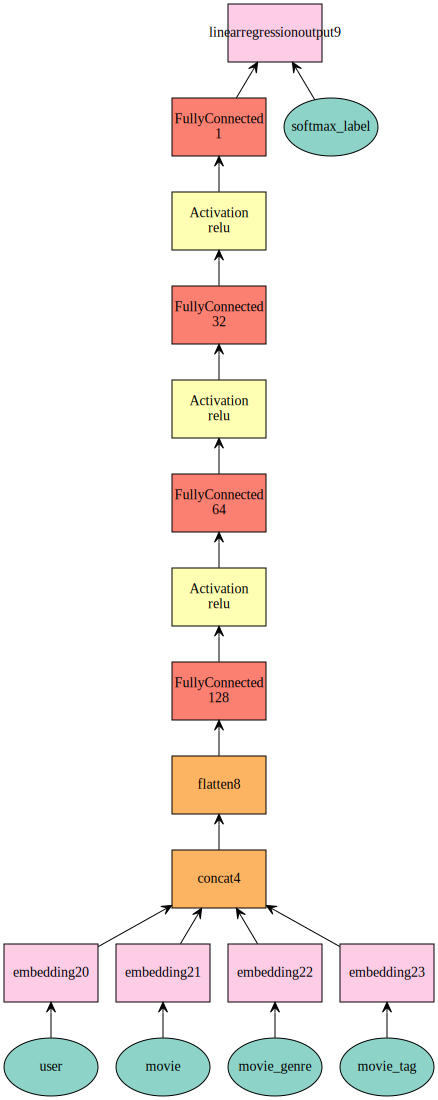

In [ ]:
# Visualize network
mx.viz.plot_network(y_pred)

In [ ]:
# Print summary
mx.viz.print_summary(y_pred)

________________________________________________________________________________________________________________________
Layer (type)                                        Output Shape            Param #     Previous Layer                  
user(null)                                                                  0                                           
________________________________________________________________________________________________________________________
embedding20(Embedding)                                                      3462325     user                            
________________________________________________________________________________________________________________________
embedding21(Embedding)                                                      3281550                                     
________________________________________________________________________________________________________________________
embedding22(Embedding)          

## 3-layer Genre-Tag

In [ ]:
X_train = mx.io.NDArrayIter({'user': train_users, 
                             'movie': train_movies, 
                             'movie_genre': train_genres, 
                             'movie_tag': train_tags}, 
                            label=train_ratings, 
                            batch_size=batch_size)
X_eval = mx.io.NDArrayIter({'user': valid_users, 
                            'movie': valid_movies, 
                            'movie_genre': valid_genres, 
                            'movie_tag': valid_tags}, 
                           label=valid_ratings, 
                           batch_size=batch_size)

user = mx.symbol.Variable("user")
user = mx.symbol.Embedding(data=user, input_dim=n_users, output_dim=25) # user = mx.symbol.Embedding(data=user, input_dim=n_users, output_dim=25)

movie = mx.symbol.Variable("movie")
movie = mx.symbol.Embedding(data=movie, input_dim=n_movies, output_dim=25) # Reduce from 25 to 20 # movie = mx.symbol.Embedding(data=movie, input_dim=n_movies, output_dim=25) # Reduce from 25 to 20

# We need to add in a third embedding layer for genre
movie_genre = mx.symbol.Variable("movie_genre")
movie_genre = mx.symbol.Embedding(data=movie_genre, input_dim=20, output_dim=5) # Set to 5

# We need to add in a fourth embedding layer for tag
movie_tag = mx.symbol.Variable("movie_tag")
movie_tag = mx.symbol.Embedding(data=movie_tag, input_dim=812, output_dim=5) # Set to 25

y_true = mx.symbol.Variable("softmax_label")

nn = mx.symbol.concat(user, movie, movie_genre, movie_tag)
nn = mx.symbol.flatten(nn)
nn = mx.symbol.FullyConnected(data=nn, num_hidden=64)
nn = mx.symbol.Activation(data=nn, act_type='relu')
nn = mx.symbol.FullyConnected(data=nn, num_hidden=32)
nn = mx.symbol.Activation(data=nn, act_type='relu')
nn = mx.symbol.FullyConnected(data=nn, num_hidden=1)

y_pred = mx.symbol.LinearRegressionOutput(data=nn, label=y_true)

model = mx.module.Module(context=mx.gpu(0), data_names=('user', 'movie', 'movie_genre','movie_tag'), symbol=y_pred)
model.fit(X_train, num_epoch=50, optimizer='adam', optimizer_params=(('learning_rate', 0.001),),
          eval_metric='rmse', eval_data=X_eval, batch_end_callback=mx.callback.Speedometer(batch_size, 250)) #num_epoch=5

INFO:root:Epoch[0] Batch [0-250]	Speed: 6983904.55 samples/sec	rmse=1.610165
INFO:root:Epoch[0] Batch [250-500]	Speed: 7178223.92 samples/sec	rmse=0.868798
INFO:root:Epoch[0] Batch [500-750]	Speed: 7130810.59 samples/sec	rmse=0.862290
INFO:root:Epoch[0] Train-rmse=1.111417
INFO:root:Epoch[0] Time cost=2.749
INFO:root:Epoch[0] Validation-rmse=0.861022
INFO:root:Epoch[1] Batch [0-250]	Speed: 7115720.58 samples/sec	rmse=0.857313
INFO:root:Epoch[1] Batch [250-500]	Speed: 7129937.83 samples/sec	rmse=0.848013
INFO:root:Epoch[1] Batch [500-750]	Speed: 7071441.67 samples/sec	rmse=0.841264
INFO:root:Epoch[1] Train-rmse=0.848757
INFO:root:Epoch[1] Time cost=2.678
INFO:root:Epoch[1] Validation-rmse=0.840956
INFO:root:Epoch[2] Batch [0-250]	Speed: 7034929.90 samples/sec	rmse=0.835585
INFO:root:Epoch[2] Batch [250-500]	Speed: 7031559.72 samples/sec	rmse=0.831526
INFO:root:Epoch[2] Batch [500-750]	Speed: 7034133.30 samples/sec	rmse=0.829172
INFO:root:Epoch[2] Train-rmse=0.832057
INFO:root:Epoch[2] T

##5-layer Genre-Tag

In [ ]:
X_train = mx.io.NDArrayIter({'user': train_users, 
                             'movie': train_movies, 
                             'movie_genre': train_genres, 
                             'movie_tag': train_tags}, 
                            label=train_ratings, 
                            batch_size=batch_size)
X_eval = mx.io.NDArrayIter({'user': valid_users, 
                            'movie': valid_movies, 
                            'movie_genre': valid_genres, 
                            'movie_tag': valid_tags}, 
                           label=valid_ratings, 
                           batch_size=batch_size)

user = mx.symbol.Variable("user")
user = mx.symbol.Embedding(data=user, input_dim=n_users, output_dim=25) 

movie = mx.symbol.Variable("movie")
movie = mx.symbol.Embedding(data=movie, input_dim=n_movies, output_dim=25)

# We need to add in a third embedding layer for genre
movie_genre = mx.symbol.Variable("movie_genre")
movie_genre = mx.symbol.Embedding(data=movie_genre, input_dim=20, output_dim=5) # Set to 5

# We need to add in a fourth embedding layer for tag
movie_tag = mx.symbol.Variable("movie_tag")
movie_tag = mx.symbol.Embedding(data=movie_tag, input_dim=812, output_dim=5) # Set to 25

y_true = mx.symbol.Variable("softmax_label")

nn = mx.symbol.concat(user, movie, movie_genre, movie_tag)
nn = mx.symbol.flatten(nn)
nn = mx.symbol.FullyConnected(data=nn, num_hidden=128)
nn = mx.symbol.Activation(data=nn, act_type='relu')
nn = mx.symbol.FullyConnected(data=nn, num_hidden=64)
nn = mx.symbol.Activation(data=nn, act_type='relu')
nn = mx.symbol.FullyConnected(data=nn, num_hidden=32)
nn = mx.symbol.Activation(data=nn, act_type='relu')
nn = mx.symbol.FullyConnected(data=nn, num_hidden=16)
nn = mx.symbol.Activation(data=nn, act_type='relu')
nn = mx.symbol.FullyConnected(data=nn, num_hidden=1)

y_pred = mx.symbol.LinearRegressionOutput(data=nn, label=y_true)

model = mx.module.Module(context=mx.gpu(0), data_names=('user', 'movie', 'movie_genre','movie_tag'), symbol=y_pred)
model.fit(X_train, num_epoch=50, optimizer='adam', optimizer_params=(('learning_rate', 0.001),),
          eval_metric='rmse', eval_data=X_eval, batch_end_callback=mx.callback.Speedometer(batch_size, 250)) #num_epoch=5

INFO:root:Epoch[0] Batch [0-250]	Speed: 5428018.87 samples/sec	rmse=1.665456
INFO:root:Epoch[0] Batch [250-500]	Speed: 5489089.83 samples/sec	rmse=0.867227
INFO:root:Epoch[0] Batch [500-750]	Speed: 5483371.92 samples/sec	rmse=0.860954
INFO:root:Epoch[0] Train-rmse=1.128696
INFO:root:Epoch[0] Time cost=3.543
INFO:root:Epoch[0] Validation-rmse=0.858809
INFO:root:Epoch[1] Batch [0-250]	Speed: 5469668.88 samples/sec	rmse=0.850972
INFO:root:Epoch[1] Batch [250-500]	Speed: 5471019.32 samples/sec	rmse=0.839827
INFO:root:Epoch[1] Batch [500-750]	Speed: 5468689.86 samples/sec	rmse=0.833977
INFO:root:Epoch[1] Train-rmse=0.841494
INFO:root:Epoch[1] Time cost=3.479
INFO:root:Epoch[1] Validation-rmse=0.834736
INFO:root:Epoch[2] Batch [0-250]	Speed: 5460926.04 samples/sec	rmse=0.829152
INFO:root:Epoch[2] Batch [250-500]	Speed: 5499372.95 samples/sec	rmse=0.824674
INFO:root:Epoch[2] Batch [500-750]	Speed: 5470674.51 samples/sec	rmse=0.821268
INFO:root:Epoch[2] Train-rmse=0.824978
INFO:root:Epoch[2] T

# Cold-start scenario

## Scenario setup

In [ ]:
# Randomly take out 10% of movies from rating matrix to build cold-start validation set
unique_mov_ids = numpy.unique(data['movieId'])
cs_movie_ids = numpy.random.choice(unique_mov_ids, size=2674, replace=False)
cs_ratings_eval = data[data['movieId'].isin(cs_movie_ids)]
cs_ratings_train = data[~data['movieId'].isin(cs_movie_ids)]

In [ ]:
# Training set
cs_train_users = cs_ratings_train['userId'].values[:] - 1 # Offset by 1 so that the IDs start at 0
cs_train_movies = cs_ratings_train['movieId'].values[:] - 1 # Offset by 1 so that the IDs start at 0
cs_train_ratings = cs_ratings_train['rating'].values[:]
cs_train_genres = numpy.array([labels[int(j)] for j in cs_train_movies])
cs_train_tags = numpy.array([label_tag[int(j)] for j in cs_train_movies])

# Validate set
cs_valid_users = cs_ratings_eval['userId'].values[:] - 1 # Offset by 1 so that the IDs start at 0
cs_valid_movies = cs_ratings_eval['movieId'].values[:] - 1 # Offset by 1 so that the IDs start at 0
cs_valid_ratings = cs_ratings_eval['rating'].values[:]
cs_valid_genres = numpy.array([labels[int(j)] for j in cs_valid_movies])
cs_valid_tags = numpy.array([label_tag[int(j)] for j in cs_valid_movies])

## Funk MF

In [ ]:
X_train = mx.io.NDArrayIter({'user': cs_train_users, 'movie': cs_train_movies}, 
                           label=cs_train_ratings, batch_size=batch_size)
X_eval = mx.io.NDArrayIter({'user': cs_valid_users, 'movie': cs_valid_movies}, 
                          label=cs_valid_ratings, batch_size=batch_size)

user = mx.symbol.Variable("user")
user = mx.symbol.Embedding(data=user, input_dim=n_users, output_dim=25)

movie = mx.symbol.Variable("movie")
movie = mx.symbol.Embedding(data=movie, input_dim=n_movies, output_dim=25)

y_true = mx.symbol.Variable("softmax_label")
y_pred = mx.symbol.sum_axis(data=(user * movie), axis=1)
y_pred = mx.symbol.flatten(y_pred)
y_pred = mx.symbol.LinearRegressionOutput(data=y_pred, label=y_true)

model = mx.module.Module(context=mx.gpu(0), data_names=('user', 'movie'), symbol=y_pred)
model.fit(X_train, 
          num_epoch=50, 
          optimizer='adam', 
          optimizer_params=(('learning_rate', 0.001),),
          eval_metric='rmse', 
          eval_data=X_eval, 
          batch_end_callback=mx.callback.Speedometer(batch_size, 250))

INFO:root:Epoch[0] Batch [0-250]	Speed: 15855439.12 samples/sec	rmse=3.361134
INFO:root:Epoch[0] Batch [250-500]	Speed: 16537373.81 samples/sec	rmse=1.794214
INFO:root:Epoch[0] Train-rmse=2.140401
INFO:root:Epoch[0] Time cost=1.220
INFO:root:Epoch[0] Validation-rmse=3.700145
INFO:root:Epoch[1] Batch [0-250]	Speed: 16153947.59 samples/sec	rmse=1.009323
INFO:root:Epoch[1] Batch [250-500]	Speed: 16298250.83 samples/sec	rmse=0.939167
INFO:root:Epoch[1] Train-rmse=0.953325
INFO:root:Epoch[1] Time cost=1.131
INFO:root:Epoch[1] Validation-rmse=3.700102
INFO:root:Epoch[2] Batch [0-250]	Speed: 16539575.38 samples/sec	rmse=0.891286
INFO:root:Epoch[2] Batch [250-500]	Speed: 15967021.24 samples/sec	rmse=0.882583
INFO:root:Epoch[2] Train-rmse=0.883990
INFO:root:Epoch[2] Time cost=1.129
INFO:root:Epoch[2] Validation-rmse=3.700084
INFO:root:Epoch[3] Batch [0-250]	Speed: 16505605.05 samples/sec	rmse=0.874326
INFO:root:Epoch[3] Batch [250-500]	Speed: 16209825.43 samples/sec	rmse=0.872086
INFO:root:Epoc

## DCF (4 layers)

In [ ]:
X_train = mx.io.NDArrayIter({'user': cs_train_users, 
                             'movie': cs_train_movies}, 
                            label=cs_train_ratings, 
                            batch_size=batch_size)
X_eval = mx.io.NDArrayIter({'user': cs_valid_users, 
                            'movie': cs_valid_movies}, 
                           label=cs_valid_ratings, 
                           batch_size=batch_size)

user = mx.symbol.Variable("user")
user = mx.symbol.Embedding(data=user, input_dim=n_users, output_dim=25) 

movie = mx.symbol.Variable("movie")
movie = mx.symbol.Embedding(data=movie, input_dim=n_movies, output_dim=25) 

y_true = mx.symbol.Variable("softmax_label")

nn = mx.symbol.concat(user, movie)
nn = mx.symbol.flatten(nn)

# Create 4 FullyConnected layers
nn = mx.symbol.FullyConnected(data=nn, num_hidden=128)
nn = mx.symbol.Activation(data=nn, act_type='relu')
nn = mx.symbol.FullyConnected(data=nn, num_hidden=64)
nn = mx.symbol.Activation(data=nn, act_type='relu')
nn = mx.symbol.FullyConnected(data=nn, num_hidden=32)
nn = mx.symbol.Activation(data=nn, act_type='relu')
nn = mx.symbol.FullyConnected(data=nn, num_hidden=1)
y_pred = mx.symbol.LinearRegressionOutput(data=nn, label=y_true)

model = mx.module.Module(context=mx.gpu(0), data_names=('user', 'movie'), symbol=y_pred)
model.fit(X_train, num_epoch=50, optimizer='adam', optimizer_params=(('learning_rate', 0.001),),
          eval_metric='rmse', eval_data=X_eval, batch_end_callback=mx.callback.Speedometer(batch_size, 250))

INFO:root:Epoch[0] Batch [0-250]	Speed: 7562986.42 samples/sec	rmse=1.475015
INFO:root:Epoch[0] Batch [250-500]	Speed: 7629649.53 samples/sec	rmse=0.865733
INFO:root:Epoch[0] Train-rmse=1.072613
INFO:root:Epoch[0] Time cost=2.487
INFO:root:Epoch[0] Validation-rmse=1.455735
INFO:root:Epoch[1] Batch [0-250]	Speed: 7642223.24 samples/sec	rmse=0.844711
INFO:root:Epoch[1] Batch [250-500]	Speed: 7599698.50 samples/sec	rmse=0.835576
INFO:root:Epoch[1] Train-rmse=0.837091
INFO:root:Epoch[1] Time cost=2.418
INFO:root:Epoch[1] Validation-rmse=1.404538
INFO:root:Epoch[2] Batch [0-250]	Speed: 7446322.90 samples/sec	rmse=0.825552
INFO:root:Epoch[2] Batch [250-500]	Speed: 7465761.09 samples/sec	rmse=0.820599
INFO:root:Epoch[2] Train-rmse=0.821255
INFO:root:Epoch[2] Time cost=2.457
INFO:root:Epoch[2] Validation-rmse=1.356875
INFO:root:Epoch[3] Batch [0-250]	Speed: 7449920.41 samples/sec	rmse=0.812915
INFO:root:Epoch[3] Batch [250-500]	Speed: 7436261.99 samples/sec	rmse=0.809340
INFO:root:Epoch[3] Tra

## Genre (4 layers)

In [ ]:
X_train = mx.io.NDArrayIter({'user': cs_train_users, 
                             'movie': cs_train_movies, 
                             'movie_genre': cs_train_genres}, 
                            label=cs_train_ratings, batch_size=batch_size)
X_eval = mx.io.NDArrayIter({'user': cs_valid_users, 
                            'movie': cs_valid_movies, 
                            'movie_genre': cs_valid_genres}, 
                           label=cs_valid_ratings, batch_size=batch_size)

user = mx.symbol.Variable("user")
user = mx.symbol.Embedding(data=user, input_dim=n_users, output_dim=25) 

movie = mx.symbol.Variable("movie")
movie = mx.symbol.Embedding(data=movie, input_dim=n_movies, output_dim=25) 

# We need to add in a third embedding layer for genre
movie_genre = mx.symbol.Variable("movie_genre")
movie_genre = mx.symbol.Embedding(data=movie_genre, input_dim=20, output_dim=5) # Set to 5

y_true = mx.symbol.Variable("softmax_label")

nn = mx.symbol.concat(user, movie, movie_genre)
nn = mx.symbol.flatten(nn)
nn = mx.symbol.FullyConnected(data=nn, num_hidden=128)
nn = mx.symbol.Activation(data=nn, act_type='relu')
nn = mx.symbol.FullyConnected(data=nn, num_hidden=64)
nn = mx.symbol.Activation(data=nn, act_type='relu')
nn = mx.symbol.FullyConnected(data=nn, num_hidden=32)
nn = mx.symbol.Activation(data=nn, act_type='relu')
nn = mx.symbol.FullyConnected(data=nn, num_hidden=1)

y_pred = mx.symbol.LinearRegressionOutput(data=nn, label=y_true)

model = mx.module.Module(context=mx.gpu(0), data_names=('user', 'movie', 'movie_genre'), symbol=y_pred)
model.fit(X_train, num_epoch=50, optimizer='adam', optimizer_params=(('learning_rate', 0.001),),
          eval_metric='rmse', eval_data=X_eval, batch_end_callback=mx.callback.Speedometer(batch_size, 250))

INFO:root:Epoch[0] Batch [0-250]	Speed: 6471996.22 samples/sec	rmse=1.517942
INFO:root:Epoch[0] Batch [250-500]	Speed: 6546670.35 samples/sec	rmse=0.866661
INFO:root:Epoch[0] Train-rmse=1.088658
INFO:root:Epoch[0] Time cost=2.872
INFO:root:Epoch[0] Validation-rmse=1.448978
INFO:root:Epoch[1] Batch [0-250]	Speed: 6523289.54 samples/sec	rmse=0.854708
INFO:root:Epoch[1] Batch [250-500]	Speed: 6517637.31 samples/sec	rmse=0.842470
INFO:root:Epoch[1] Train-rmse=0.844299
INFO:root:Epoch[1] Time cost=2.802
INFO:root:Epoch[1] Validation-rmse=1.421868
INFO:root:Epoch[2] Batch [0-250]	Speed: 6531129.65 samples/sec	rmse=0.830002
INFO:root:Epoch[2] Batch [250-500]	Speed: 6500167.00 samples/sec	rmse=0.825290
INFO:root:Epoch[2] Train-rmse=0.825641
INFO:root:Epoch[2] Time cost=2.812
INFO:root:Epoch[2] Validation-rmse=1.354134
INFO:root:Epoch[3] Batch [0-250]	Speed: 6420713.70 samples/sec	rmse=0.817593
INFO:root:Epoch[3] Batch [250-500]	Speed: 6447306.48 samples/sec	rmse=0.813274
INFO:root:Epoch[3] Tra

## Genre-Tag (4 layers)

In [ ]:
X_train = mx.io.NDArrayIter({'user': cs_train_users, 
                             'movie': cs_train_movies, 
                             'movie_genre': cs_train_genres, 
                             'movie_tag': cs_train_tags}, 
                            label=cs_train_ratings, 
                            batch_size=batch_size)
X_eval = mx.io.NDArrayIter({'user': cs_valid_users, 
                            'movie': cs_valid_movies, 
                            'movie_genre': cs_valid_genres, 
                            'movie_tag': cs_valid_tags}, 
                           label=cs_valid_ratings, 
                           batch_size=batch_size)

user = mx.symbol.Variable("user")
user = mx.symbol.Embedding(data=user, input_dim=n_users, output_dim=25) 

movie = mx.symbol.Variable("movie")
movie = mx.symbol.Embedding(data=movie, input_dim=n_movies, output_dim=25) 

# We need to add in a third embedding layer for genre
movie_genre = mx.symbol.Variable("movie_genre")
movie_genre = mx.symbol.Embedding(data=movie_genre, input_dim=20, output_dim=5) # Set to 5

# We need to add in a fourth embedding layer for tag
movie_tag = mx.symbol.Variable("movie_tag")
movie_tag = mx.symbol.Embedding(data=movie_tag, input_dim=812, output_dim=25) # Set to 25

y_true = mx.symbol.Variable("softmax_label")

nn = mx.symbol.concat(user, movie, movie_genre, movie_tag)
nn = mx.symbol.flatten(nn)
nn = mx.symbol.FullyConnected(data=nn, num_hidden=128)
nn = mx.symbol.Activation(data=nn, act_type='relu')
nn = mx.symbol.FullyConnected(data=nn, num_hidden=64)
nn = mx.symbol.Activation(data=nn, act_type='relu')
nn = mx.symbol.FullyConnected(data=nn, num_hidden=32)
nn = mx.symbol.Activation(data=nn, act_type='relu')
nn = mx.symbol.FullyConnected(data=nn, num_hidden=1)

y_pred = mx.symbol.LinearRegressionOutput(data=nn, label=y_true)

model = mx.module.Module(context=mx.gpu(0), data_names=('user', 'movie', 'movie_genre','movie_tag'), symbol=y_pred)
model.fit(X_train, num_epoch=50, optimizer='adam', optimizer_params=(('learning_rate', 0.001),),
          eval_metric='rmse', eval_data=X_eval, batch_end_callback=mx.callback.Speedometer(batch_size, 250)) #num_epoch=5

INFO:root:Epoch[0] Batch [0-250]	Speed: 5328808.10 samples/sec	rmse=1.461403
INFO:root:Epoch[0] Batch [250-500]	Speed: 5408607.30 samples/sec	rmse=0.864844
INFO:root:Epoch[0] Train-rmse=1.068381
INFO:root:Epoch[0] Time cost=3.483
INFO:root:Epoch[0] Validation-rmse=1.255059
INFO:root:Epoch[1] Batch [0-250]	Speed: 5397168.87 samples/sec	rmse=0.856675
INFO:root:Epoch[1] Batch [250-500]	Speed: 5404164.03 samples/sec	rmse=0.846738
INFO:root:Epoch[1] Train-rmse=0.847047
INFO:root:Epoch[1] Time cost=3.382
INFO:root:Epoch[1] Validation-rmse=1.241261
INFO:root:Epoch[2] Batch [0-250]	Speed: 5378831.03 samples/sec	rmse=0.831352
INFO:root:Epoch[2] Batch [250-500]	Speed: 5390820.28 samples/sec	rmse=0.825792
INFO:root:Epoch[2] Train-rmse=0.826278
INFO:root:Epoch[2] Time cost=3.393
INFO:root:Epoch[2] Validation-rmse=1.206551
INFO:root:Epoch[3] Batch [0-250]	Speed: 5384828.38 samples/sec	rmse=0.818045
INFO:root:Epoch[3] Batch [250-500]	Speed: 5381750.69 samples/sec	rmse=0.813098
INFO:root:Epoch[3] Tra